code copied from: https://www.kaggle.com/fiorenza2/journey-to-the-top-10

# Journey to the top 10%

With most kernels/notebooks, you get the following steps, presented one after another:

1. Data Exploration
2. Data Engineering
3. Data Modelling
4. Results

This doesn't reflect the actual process of how you take part Kaggle competitions; in reality parts 1 through to 3 are cycled through repeatedly, in varying orders, until we finally hit stage 4.

Therefore, this is a notebook which more closely documents the actual process I took. The aim is twofold:

1. Posterity, as I will want to revisit the exact thoughts/rationales I had behind making certain choices.
2. Pedagogical, as it may benefit others to understand how I hacked and stumbled my way through this competition.

Of course, as much as it pains me, the process will be abridged as otherwise it would be far too long (it took me about 2 weeks of effort with 5 different notebooks).

At the time of writing, the below code will get you into the top 10% of the "House Prices: Advanced Regression Techniques" tutorial competition on Kaggle. I tried to do as much of this on my own as possible, but give credit where it's due when I've adopted ideas from other Kagglers.

I also understand that some people will want a TL;DR, so see below for a summary of the contents so you can skip to the juicy bits (probably sections 5.C and 6.A-C):

# Contents:

1. Initial Data Exploration
2. Create a Baseline Model
3. Feature Engineering: First Pass
4. Different Models
5. More Data Modelling and Exploration
    1. Outliers (manual and statistical detection)
    2. Overfitting
    3. The FINAL engineering steps in one section
6. Final Modelling
    1. Lasso
    2. Ensembled XGBoost
    3. Ensembled Everything
7. Afterword

# 1. Initial Data Exploration

The first step is always to read the data description if avaialble. We need to build a foundation of knowledge on which we can stand, so that we can make informed decisions further down the line. The approach I will take is relatively straightforward; look for interesting things in the data which we can test out later.

The first thing to notice is that this dataset is that there are a fair few variables. Furthermore, there seems to be categorical features listed as numbers/ordinals (MSSubClass, MoSold), and the exact opposite issue (Quality measures). We will make a note of this and see if it improves our models later.

Interestingly, it forewarns us to the presence of missing variables, which for the most case are due to a parameter not being relevant (i.e.: a one story flat will never have a properties relating to a second story).

The next thing to do is to load in the training data and understand what we will be fitting our models to.

In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats

In [2]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

As expected, there are a number of fields with missing values, and some fields with very few actual values. This is not necessarily a bad thing, as we can impute values where necessary. Furthermore, perhaps setting them straight to zero may be better?

## Correlations

As a starting point, let's do a quick heatmap plot. Primarily because they look nice, but also because they can give us a bit of information about the data :)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

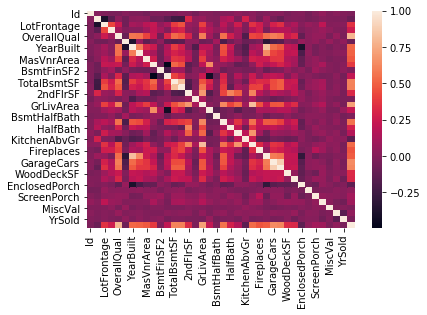

In [4]:
sns.heatmap(data=train.corr())
plt.show()
plt.gcf().clear()

Well what does this show us? For starters, 'Id' seems to be pretty irrelevant. Sometimes in Kaggle, the Id can represent some sort of temporal/ordinal factor, but it does not seem to be the case here. In any case, if some sort of temporal factor was present, we'd be able to get it from MoSold/YrSold, neither of which seem to possess much correlation.

Luckily, SalePrice seems to have correlations with a fair few other features. Ones which particularly jump out are OverallQual and GrLivArea, which is not hugely surprising. We should expect to see these appearing high in feature importance measures later on.

Finally, LotArea seems to be highly correlated, but missing a lot of values (over 200). This is important to note during imputation, and means we ought to spend a bit longer on this variable.

## Skews

Recall the form of a standard linear regression

$$
y = ax_1 + bx_2 + cx_3 + ...
$$

Clearly our dependant ($y$) needs to be proportional to the other variables. This cannot be the case if the $y$ is say skewed, but the other parameters are normally distributed. Whilst this shouldn't affect tree-based regressors, it can have a drastic impact on the performance of regression based algorithms (OLS, Lasso, Ridge, KRR, etc.).

With this in mind, let's view the skews:

In [5]:
train.skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

Clearly some variables display intense skews, so we'll need to address this later on. Note at this point our target variable is skewed as well (SalePrice), so the potential issue highlighted above does indeed apply.

# 2. Create a Baseline Model

Right, we've identified a few different things to try out, namely:

1. Careful treatment of missing value imputation
2. Converting categoricals into numericals
3. Converting numericals into categoricals
4. Unskewing variables

Before we bulldoze in with these, it is best to get a quick baseline model with little to no data engineering so we can at least have some sort of benchmark against which we can assess the effectiveness of our engineering steps.

## Train

First steps, create a copy of the data, and turn the categorical data into dummy variables.

In [6]:
train_d = train.copy()
train_d = pd.get_dummies(train_d)

Now remove the original categorical variables (these will cause our SKLearn to spew out errors if left in)

In [7]:
keep_cols = train_d.select_dtypes(include=['number']).columns
train_d = train_d[keep_cols]

Now fill the NAs with means (NAs will similarly cause errors)

In [8]:
train_d = train_d.fillna(train_d.mean())

All done, let's do the test data.

## Test

In [129]:
test = pd.read_csv('test.csv')

In [10]:
test_d = test.copy()
test_d = pd.get_dummies(test_d)

In [11]:
test_d = test_d.fillna(test_d.mean())

Some dummy variables exist in train but not test; create them in the test set and set to zero.

In [12]:
for col in keep_cols:
    if col not in test_d:
        test_d[col] = 0

In [13]:
test_d = test_d[keep_cols]

## Modelling

Let's use a random forest as this should partially remove the dependancy on skews that we have with linear regression based modelling. Furthermore, RFs tend to perform quite well in general. Let's take measures such as CrossVal score and perform a GridSearch over the hyperparameter space.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [15]:
rf_test = RandomForestRegressor(n_jobs = -1)
params = {'max_depth': [20,30,40], 'n_estimators': [500], 'max_features': [100,140,160]}
gsCV = GridSearchCV(estimator = rf_test, param_grid = params, cv = 5, n_jobs = -1, verbose = 3)
gsCV.fit(train_d.drop('SalePrice',axis = 1),train_d['SalePrice'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_features=100, max_depth=20, n_estimators=500 ................
[CV] max_features=100, max_depth=20, n_estimators=500 ................
[CV] max_features=100, max_depth=20, n_estimators=500 ................
[CV] max_features=100, max_depth=20, n_estimators=500 ................
[CV]  max_features=100, max_depth=20, n_estimators=500, score=0.8717376176382379, total=  10.1s
[CV]  max_features=100, max_depth=20, n_estimators=500, score=0.8450099530424443, total=  10.2s
[CV]  max_features=100, max_depth=20, n_estimators=500, score=0.8949543955926036, total=  10.2s
[CV]  max_features=100, max_depth=20, n_estimators=500, score=0.8966532660656006, total=  10.1s
[CV] max_features=100, max_depth=20, n_estimators=500 ................
[CV] max_features=140, max_depth=20, n_estimators=500 ................
[CV] max_features=140, max_depth=20, n_estimators=500 ................
[CV] max_features=140, max_depth=20, n_estimators=500 .....

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min


[CV]  max_features=140, max_depth=30, n_estimators=500, score=0.8410563620416486, total=  15.3s
[CV] max_features=160, max_depth=30, n_estimators=500 ................
[CV]  max_features=160, max_depth=30, n_estimators=500, score=0.8884658813841241, total=  17.0s
[CV] max_features=160, max_depth=30, n_estimators=500 ................
[CV]  max_features=160, max_depth=30, n_estimators=500, score=0.8417172633006158, total=  17.5s
[CV] max_features=100, max_depth=40, n_estimators=500 ................
[CV]  max_features=160, max_depth=30, n_estimators=500, score=0.8722736559282445, total=  17.7s
[CV] max_features=100, max_depth=40, n_estimators=500 ................
[CV]  max_features=160, max_depth=30, n_estimators=500, score=0.8920969072584214, total=  17.4s
[CV] max_features=100, max_depth=40, n_estimators=500 ................
[CV]  max_features=100, max_depth=40, n_estimators=500, score=0.8972752579690704, total=  13.9s
[CV] max_features=100, max_depth=40, n_estimators=500 ...............

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [100, 140, 160], 'max_depth': [20, 30, 40], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [16]:
print(gsCV.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


(NB: I will stop Grid Searching henceforth and just print the best hyperparameters as it takes ages and only needs to be demonstrated once)

In [19]:
rf_test = RandomForestRegressor(max_depth=20, n_estimators=500, max_features = 100, 
                                n_jobs=-1, oob_score=True, random_state=1234)
cv_score = cross_val_score(rf_test, train_d.drop('SalePrice', axis = 1), train_d['SalePrice'], cv = 5, n_jobs = -1)

In [20]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.869510076759356


In [23]:
#fast try and submit
rf_test.fit(train_d.drop('SalePrice',axis = 1),train_d['SalePrice'])
pred = rf_test.predict(test_d.drop('SalePrice', axis = 1))
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = pred
sub.to_csv('fastTry.csv', index = False)
#0.14629

The R^2 score seems strong. Submitting the outputs from the model nets us a score of 0.14636, which is actually pretty decent, but puts us in the top 65%. This also shows the strength of this competition; whilst the difference in this and a top 10% score (0.116x) is minimal, in reality 55% of the competition stands between us and our goal! A bit harder than the Titanic one I think...

It's a good thing then that we've got a few ideas down our sleaves, let's get on with it.

# 3. Feature Engineering: First Pass

We'll try a few things:

1. LotFrontage Imputation
2. Medians vs Means
3. Numeric to Categoric
4. Categoric to Numerical
5. Dropping columns
6. 'None' vs NA
7. Unskewing data

and see where we end up.

## 1. LotFrontage Imputation

We've identified LotFrontage as a potential sticking point, so let's think of how to address this. Either we can use just 0s (as these houses don't have fronts, so this is technically true), or impute values based on medians, be it a global median or some sort of conditional median. Let's try 0s and conditional medians, and see what works better.

### 0s

In [24]:
train_0 = train.copy()

In [25]:
null_index = train_0.LotFrontage.isnull()
train_0.loc[null_index,'LotFrontage'] = 0

In [26]:
train_0 = pd.get_dummies(train_0)

In [27]:
keep_cols = train_0.select_dtypes(include=['number']).columns
train_0 = train_0[keep_cols]

In [28]:
train_0 = train_0.fillna(train_0.mean())

In [29]:
rf_test = RandomForestRegressor(max_depth=20, n_estimators=500, max_features = 100, oob_score=True,
                                n_jobs=-1, random_state=1234)
cv_score = cross_val_score(rf_test, train_0.drop('SalePrice', axis = 1), train_0['SalePrice'], cv = 5, n_jobs=-1)

In [30]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8688937772638203


This scores basically no difference in-sample, so let's refrain from using this.

### Conditional Medians

Perhaps we should impute medians, i.e.: pretend that these properties had lots. In reality it's usually good enough to just use a generic median, but let's try to be clever. In my experience, it would make sense for lot size to be related to the areas in which houses are located. Let's see if there's any significant difference conditioning on neighbourhood. 

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


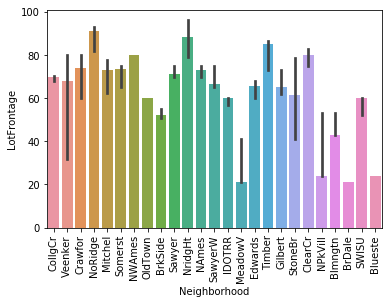

In [31]:
sns.barplot(data=train,x='Neighborhood',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()
plt.gcf().clear()

Looks like a good thing to condition on. Let's use this instead.

In [32]:
gb_neigh_LF = train['LotFrontage'].groupby(train['Neighborhood'])

In [33]:
train_LFm = train.copy()

In [34]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_LFm.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

Does this help? Let's see.

In [35]:
train_LFm = pd.get_dummies(train_LFm)

In [36]:
keep_cols = train_LFm.select_dtypes(include=['number']).columns
train_LFm = train_LFm[keep_cols]

In [37]:
train_LFm = train_LFm.fillna(train_LFm.mean())

In [38]:
rf_test = RandomForestRegressor(max_depth=20, n_estimators=500, max_features = 100, oob_score=True, 
                                n_jobs=-1, random_state= 1234)
cv_score = cross_val_score(rf_test, train_LFm.drop('SalePrice', axis = 1), train_LFm['SalePrice'], cv = 5, n_jobs=-1)

In [39]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.868806640260345


Again very similar. We will need to impute this at some point, as the non-tree based algorithms will require this. It seems to perform mildly better than turning it into 0s, but it's incredibly close. Let's go with this for now.

## 2. Medians vs Means

In my haste I ran with means instead of the medians. Of course as any good statistician will tell you, a median is a more robust statistic than a mean as it's less/not affected by outliers. Let's see if converting to a different statistic will affect our model's ability to generalise.

In [40]:
train_med = train.copy()

In [41]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_med.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [42]:
train_med = pd.get_dummies(train_med)

In [43]:
keep_cols = train_med.select_dtypes(include=['number']).columns
train_med = train_med[keep_cols]

In [44]:
train_med = train_med.fillna(train_med.median())

In [49]:
rf_test = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, 
                                n_jobs=-1, random_state=1234)
cv_score = cross_val_score(rf_test, train_med.drop('SalePrice', axis = 1), train_med['SalePrice'], cv = 5, n_jobs=-1)

In [50]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8699353054451968


Again a slight increase. Let's see how we're doing on the leaderboard now as a quick check.

In [51]:
rf_test.fit(train_med.drop('SalePrice',axis = 1),train_med['SalePrice'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=1234, verbose=0, warm_start=False)

In [59]:
pred = rf_test.predict(test_d.drop('SalePrice', axis = 1))
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = pred
sub.to_csv('medTry.csv', index = False)
#0.14635 no better!

The score is now 0.14559, which is a very marginal improvement. Having said this, such small gains will make all the difference between the top scores near the top 10%!

## 3. Numeric to Categoric

Now lets examine the numerics which ought to be categorics. In the interests of being concise, I experimented with the following:

1. MSSubClass
2. MoSold
3. YrSold

And found improved performance with only MSSubClass converted. This can be illustrated below:

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


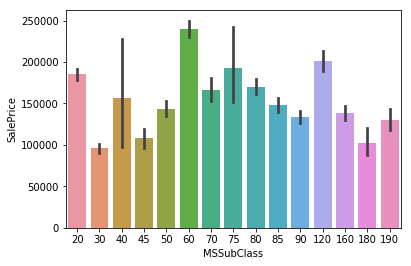

In [53]:
sns.barplot(data=train, x='MSSubClass', y='SalePrice')
plt.show()
plt.gcf().clear()

 Therefore we will be using this going forward.

## INTERJECTION: Change models?

At this point I'd thought it would be wise to try a different modelling technique. Even with the best will in the world, I was getting issues with the ever-reliable random forest. Namely, there was huge noise in my cross validation score, which was making choosing the right data engineering steps a bit of a nightmare. Also RF regression is tediously slow. Enter XGBoost.

I won't explain how XGBoost works, as there is literature online which can explain it better than I ever will, but suffice to say it is similar to RF in that it combines a lot of trees together, but unlike RF it doesn't build them in a random manner.

In [54]:
from xgboost.sklearn import XGBRegressor

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_med.drop(['SalePrice','Id'], axis = 1), train_med['SalePrice'], cv = 5, n_jobs = -1)

In [56]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8931122262679108


In [60]:
xgb_test.fit(train_med.drop(['SalePrice','Id'], axis = 1), train_med['SalePrice'])
pred = xgb_test.predict(test_d.drop(['SalePrice','Id'], axis = 1))
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = pred
sub.to_csv('xgbTry.csv', index = False)
#0.12870 WOW!

This is quite a bit stronger than RF, submitting yields 0.13031, which puts us strongly in the top 50%. A while to go yet, but we are moving in the right direction. Furthermore, let's move to using XGBoost as our regression method now.

## 4. Categoric to Numeric

This is interesting. Some of the fields regarding the quality of the property are 'secretly' ordinal. Case in point, the field entitled BsmtCond, which has different quality ratings. Perhaps turning these into their numeric correspondent will improve performance, as we will be able to mine out better trends.

## This is very important since pd.get_dummies might not be relevent and convert the data to number would represent them better!

In [61]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [68]:
dic_num = {'None': 0, 'NA': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [63]:
train_c2n = train.copy()

## There are some numeric data are actually categorical, should be careful as well!

In [64]:
train_c2n['MSSubClass'] = train_c2n['MSSubClass'].astype('category')

In [65]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_c2n.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [69]:
for col in has_rank:
    train_c2n[col+'_2num'] = train_c2n[col].map(dic_num)

In [70]:
train_c2n = pd.get_dummies(train_c2n)

In [71]:
train_cols = train_c2n.select_dtypes(include=['number']).columns
train_c2n = train_c2n[train_cols]

In [72]:
train_c2n = train_c2n.fillna(train_c2n.median())

In [73]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_c2n.drop(['SalePrice','Id'], axis = 1), train_c2n['SalePrice'], cv = 5, n_jobs=-1)

In [74]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8950398236281201


This is a strong increase. Let's move onto dropping columns.

## 5. Dropping Columns

One thing to note about this dataset is the lack of data (~1500 rows) and with it the curse of dimensionality. One way around this is to remove the number of columns, specifically ones which are carry little information.

I experimented with this, and found that removing columns where 97% of the data was a single class to be a good method.

In [76]:
from statistics import mode
#mode: most common value

In [77]:
low_var_cat = [col for col in train.select_dtypes(exclude=['number']) if 1 - sum(train[col] == mode(train[col]))/len(train) < 0.03]
low_var_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

Let's drop these columns.

In [78]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [79]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [80]:
train_col = train.copy()

In [81]:
train_col = train_col.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1)

In [82]:
train_col['MSSubClass'] = train_col['MSSubClass'].astype('category')

In [83]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_col.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [84]:
for col in has_rank:
    train_col[col+'_2num'] = train_col[col].map(dic_num)

In [85]:
train_col = pd.get_dummies(train_col)

In [86]:
train_cols = train_col.select_dtypes(include=['number']).columns
train_col = train_col[train_cols]

In [87]:
train_col = train_col.fillna(train_col.median())

In [88]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_col.drop(['SalePrice','Id'], axis = 1), train_col['SalePrice'], cv = 5, n_jobs=-1)

In [89]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8984167970843178


A moderate increase, so let's continue.

## 6. 'None' vs NA

So we got around the issue with NAs in the numerical data by replacing with the medians. However, what about with categoric? Up to now we've encoded these as NA, which means when the dummy variables are created they effectively get dropped. Instead, let's create a new class called 'None' for when the feature doesn't exist for a property (i.e.: a property without a basement), or in the case of a genuine missing value, replace with the mode.

In [93]:
cat_hasnull = [col for col in train.select_dtypes(['object']) if train[col].isnull().any()]
cat_hasnull

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

We see that all these fields apart from 'Electrical' have NAs denoting that there is none of that item in the house (i.e.: no Garage). Therefore let's replace these with the string 'None' and the Electrical field with the mode value.

In [94]:
cat_hasnull.remove('Electrical')

In [95]:
mode_elec = mode(train['Electrical'])
mode_elec

'SBrkr'

So the mode is SBrkr. Let's use this as the replacement.

In [96]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [97]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [98]:
cat_hasnull = [col for col in train.select_dtypes(['object']) if train[col].isnull().any()]

In [99]:
cat_hasnull.remove('Electrical')

In [100]:
train_none = train.copy()

In [101]:
train_none = train_none.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1)

In [102]:
train_none['MSSubClass'] = train_none['MSSubClass'].astype('category')

In [103]:
for col in cat_hasnull:
    null_idx = train_none[col].isnull()
    train_none.loc[null_idx, col] = 'None'

In [104]:
null_idx_el = train_none['Electrical'].isnull()
train_none.loc[null_idx_el, 'Electrical'] = 'SBrkr'

In [105]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_none.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [106]:
for col in has_rank:
    train_none[col+'_2num'] = train_none[col].map(dic_num)

In [107]:
train_none = pd.get_dummies(train_none)

In [108]:
train_cols = train_none.select_dtypes(include=['number']).columns
train_none = train_none[train_cols]

In [109]:
train_none = train_none.fillna(train_none.median())

In [110]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_none.drop(['SalePrice','Id'], axis = 1), train_none['SalePrice'], cv = 5, n_jobs=-1)

In [111]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8973817592310545


A nice increase! Let's keep going.

## 7. Unskewing Data

As aforementioned, if we want to look at more traditional regression techniques, we need to address the skewness that exists in our data. Interestingly, if you were to try a Lasso model with the current data, you'd get something in between XGBoost and RandomForest. This bodes well :)

In [112]:
cols_skew = [col for col in train_none if '_2num' in col or '_' not in col]
train_none[cols_skew].skew()

Id                   0.000000
LotFrontage          2.212959
LotArea             12.207688
OverallQual          0.216944
OverallCond          0.693067
YearBuilt           -0.613461
YearRemodAdd        -0.503562
MasVnrArea           2.677616
BsmtFinSF1           1.685503
BsmtFinSF2           4.255261
BsmtUnfSF            0.920268
TotalBsmtSF          1.524255
1stFlrSF             1.376757
2ndFlrSF             0.813030
LowQualFinSF         9.011341
GrLivArea            1.366560
BsmtFullBath         0.596067
BsmtHalfBath         4.103403
FullBath             0.036562
HalfBath             0.675897
BedroomAbvGr         0.211790
KitchenAbvGr         4.488397
TotRmsAbvGrd         0.676341
Fireplaces           0.649565
GarageYrBlt         -0.678333
GarageCars          -0.342549
GarageArea           0.179981
WoodDeckSF           1.541376
OpenPorchSF          2.364342
EnclosedPorch        3.089872
3SsnPorch           10.304342
ScreenPorch          4.122214
PoolArea            14.828374
MiscVal   

In addition to the original values, we have some new skewed values of the _2num variety (i.e.: our categorics converted into numbers). In the interests of being concise, I found that unskewing values with a skewness magnitude above 1 to give the best results.

In [113]:
cols_unskew = train_none[cols_skew].columns[abs(train_none[cols_skew].skew()) > 1]

In [114]:
train_unskew = train_none.copy()

In [115]:
for col in cols_unskew:
    train_unskew[col] = np.log1p(train_none[col])

In [116]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'], cv = 5, n_jobs=-1)

In [117]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.907485002458189


In [134]:
#Try to submit and check the score

test_d = test.copy()
test_d = test_d.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1)
test_d['MSSubClass'] = test_d['MSSubClass'].astype('category')
for col in cat_hasnull:
    null_idx = test_d[col].isnull()
    test_d.loc[null_idx, col] = 'None'
    
null_idx_el = test_d['Electrical'].isnull()
test_d.loc[null_idx_el, 'Electrical'] = 'SBrkr'

for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = test_d['LotFrontage'].isnull() & (test_d['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    test_d.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

for col in has_rank:
    test_d[col+'_2num'] = test_d[col].map(dic_num)

test_d = pd.get_dummies(test_d)

for col in train_cols:
    try: 
        test_d[col]
    except:
        test_d[col] = 0

test_d = test_d[train_cols]

test_d = test_d.fillna(train_none.median())

for col in cols_unskew:
    test_d[col] = np.log1p(test_d[col])

In [138]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
xgb_test.fit(train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'])
pred = xgb_test.predict(test_d.drop(['SalePrice', 'Id'], axis = 1))

sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = np.expm1(pred)
sub.to_csv('xgbc2nTry.csv', index = False)

#0.12974 no better~~~

Interestingly enough the CV score for the XGBoost model improves. Perhaps this is down to unskewing the sale price, which reduces the heteroskedacisity of the target, making it easier to predict.

For reference, let us submit. We now get a score of 0.12741, which is a big jump in the right direction, putting us in the top 39%.

# 4. Different Models: Lasso

We've addressed a lot of the issues holding us back when using a linear model. In terms of which linear models to use, there are really 3 which are popular:

1. Lasso
2. Ridge
3. Elastic Net (combination of Lasso and Ridge)

I've tried all 3 with this data set, and Lasso is by far and away the most performant. If you were to try the other 2, you will find a huge amount of overfit on the training set, even with cross validation.

With this knowledge, let's get lazy and use the LassoCV algorithm. This is effectively the same as the standard Lasso algorithm, but it will use cross validation to figure out the best parameters each time you use the model. This saves having to perform gridsearch, and typically gives identical performance. An important thing to note with these types of algorithms is the need to scale the data so that the feature space has the same sort of magnitudes in each feature's direction.

In [139]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [140]:
scaler = StandardScaler()
LCV = LassoCV()
scale_LCV = Pipeline([('scaler',scaler),('LCV',LCV)])

cv_score = cross_val_score(scale_LCV, train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'], cv = 5, n_jobs=-1)

In [141]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.9035868593557366


In [145]:
scale_LCV.fit(train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'])

pred = scale_LCV.predict(test_d.drop(['SalePrice', 'Id'], axis = 1))
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = np.expm1(pred)
sub.to_csv('lcvTry.csv', index = False)

#0.12302 better!!

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


A strong score. Submitting gives us 0.12303. Incredibly this destroys the XGBoost score, which goes to show that you can't always trust your CV score. In any case, we are in the top 30%.

The beauty of Lasso is that it will drop features thanks to the use of the L1-norm. Of course this can be misleading, in the same way that a random forest's variable importances can be misleading, as having two competing but highly correlated features will mean one will get suppressed despite being highly predictive.

For our interest, let's see what didn't get dropped, and had high weights:

In [146]:
scale_LCV.fit(train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'])

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LCV', LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

In [147]:
lasso_w = scale_LCV.named_steps['LCV'].coef_
cols= train_unskew.drop(['SalePrice','Id'], axis=1).columns

In [148]:
cols_w = pd.DataFrame()
cols_w['Features'] = cols
cols_w['LassoWeights'] = lasso_w
cols_w['LassoWeightsMag'] = abs(lasso_w)

In [149]:
cols_w[cols_w.LassoWeights==0]

,Features,LassoWeights,LassoWeightsMag
0,LotFrontage,0.0,0.0
6,MasVnrArea,0.0,0.0
8,BsmtFinSF2,-0.0,0.0
9,BsmtUnfSF,-0.0,0.0
12,2ndFlrSF,0.0,0.0
13,LowQualFinSF,-0.0,0.0
16,BsmtHalfBath,0.0,0.0
19,BedroomAbvGr,0.0,0.0
21,TotRmsAbvGrd,0.0,0.0
23,GarageYrBlt,0.0,0.0


Funnily enough, LotFrontage gets dropped! That will teach us next time to spend so much time data engineering :) Joking aside, it looks like a lot of dummy variables get removed. What about the important features?

In [150]:
cols_w.sort_values(by='LassoWeightsMag',ascending=False)[:15]

,Features,LassoWeights,LassoWeightsMag
14,GrLivArea,0.124124,0.124124
2,OverallQual,0.069507,0.069507
4,YearBuilt,0.041406,0.041406
24,GarageCars,0.040665,0.040665
3,OverallCond,0.036772,0.036772
1,LotArea,0.034848,0.034848
59,MSZoning_C (all),-0.028976,0.028976
7,BsmtFinSF1,0.024690,0.024690
11,1stFlrSF,0.021916,0.021916
89,Neighborhood_Crawfor,0.018437,0.018437


Not too many surprises here. Properties in commercial areas are worth less, bigger houses and garages are worth more, as are good quality houses. Furthermore, a bit of in depth cyberstalking of the neighborhoods seems to back up the numbers.

# 5. More Data Exploration and Engineering

We've done well but we've hit a bit of an impasse. We've scrabbled up into the top 30%, which is the easy part. Now however, we will need to take careful consideration about the data we have and creative ways of treating it which will provide us with the final push that we need to make the top 10%.

## Outliers?

For those of you familiar with classification problems, outliers aren't usually too big a deal. Since the target is only 1 or 0, the impact of these points isn't that large as long as we have a decently sized population (which we just about do with 1500). However with regression it's a different story.

I can highly recommend reading the following [lecture notes](https://quantoid.net/files/702/lecture9.pdf); in short, we can now turn to econometrics to help us deal with the effect of outliers. I'm going to outline two approaches, both of which achieve similar results.

### Manually Detect Outliers

Heuristic but effective. The way we ought to approach this is to look at our Lasso model and identify which features have the largest weightings, and therefore effect on the final prediction. Luckily we've just done this, so let's plot univariate distributions against the SalePrice for the top 5 important variables:

In [151]:
top5_feats = list(cols_w.sort_values(by='LassoWeightsMag',ascending=False)[:5].Features)

In [152]:
def print_scatters(df_in, cols, against):   
    plt.figure(1)
    # sets the number of figure row (ie: for 10 variables, we need 5, for 9 we 
    # need 5 as well)
    rows = math.ceil(len(cols)/2)
    f, axarr = plt.subplots(rows, 2, figsize=(10, rows*3))
    # for each variable you inputted, plot it against the dependant
    for col in cols:
        ind = cols.index(col)
        i = math.floor(ind/2)
        j = 0 if ind % 2 == 0 else 1
        if col != against:
            sns.regplot(data = df_in, x=col, y=against, fit_reg=False, ax=axarr[i,j])
        else:
            sns.distplot(a = df_in[col], ax=axarr[i,j])
        axarr[i, j].set_title(col)
    f.text(-0.01, 0.5, against, va='center', rotation='vertical', fontsize = 12)
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

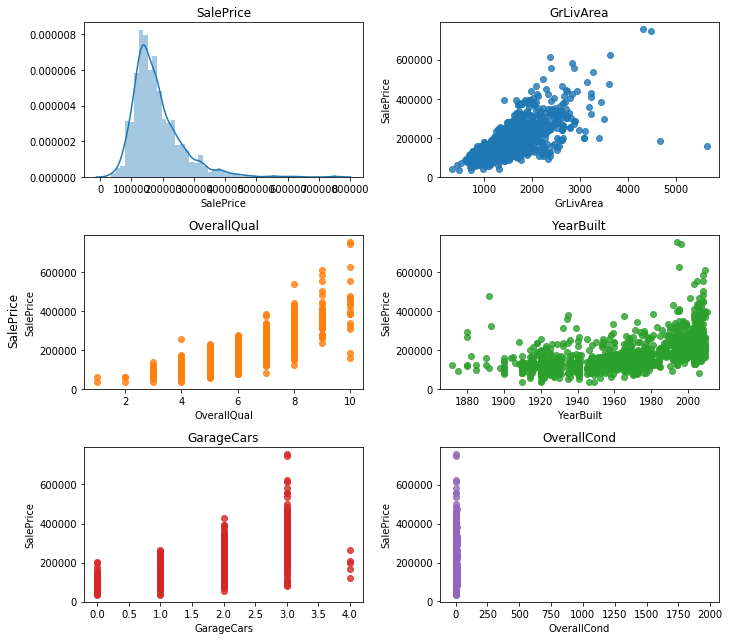

In [153]:
print_scatters(df_in=train,cols=['SalePrice']+top5_feats,against='SalePrice')

Immediately two points jump out, both of which are GrLivArea, the most important feature. In case you haven't spotted them, look at the two houses above 4500 sqft in living area. These are the two biggest houses yet are also very cheap. This is a problem, as if you look at the lecture notes linked above, they are outliers with high leverage, meaning they can cause huge overfit to them. Let's do a bit more analysis:

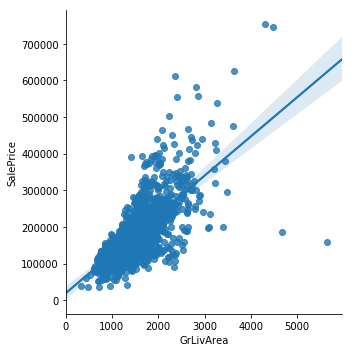

In [154]:
sns.lmplot(data=train, x='GrLivArea',y='SalePrice')
plt.show()
plt.gcf().clear()

Now removing these two:

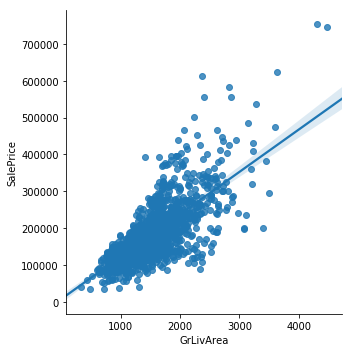

In [155]:
sns.lmplot(data=train[train.GrLivArea < 4500], x='GrLivArea',y='SalePrice')
plt.show()
plt.gcf().clear()

This is a remarkable change, as simply removing two points has resulted in a visible shift in the curve, despite the effect of the remaining data. Furthermore, the confidence interval of our plots has improved massively.

Submitting confirms the necessecity to remove these points, with a nice improved score of 0.12174. We are now in the top 27%.

Clearly these outliers were preventing our model from generalising onto new data!

### A more statistical approach?

Of course we might have juts gotten lucky by stumbling upon these two outliers. Why don't we try something more analytical, and therefore repeatable?

If you refer to the notes linked above, you can find an interesting statistical test described on slides 29 onwards. Effectively we can do Leave-One-Out with a OLS, and then perform hypothesis tests on the standard deviation of the residuals (they are t-distributed), allowing us to determine which points have a significant effect on the fit of our models. To me this makes sense since the model used is OLS, and the Lasso belongs to this family of regressors.

The Bonferroni corrected test is included in Statsmodels, so we'll use it here. Note that this takes a very long time to run, so I'll simply post the code but it is up to you to run it.

In [156]:
import statsmodels.api as sm

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [157]:
y = train_unskew['SalePrice']
X = train_unskew.drop(['SalePrice','Id'], axis = 1)

In [158]:
model = sm.OLS(y,X)

In [159]:
results = model.fit()

In [160]:
bonf_test = results.outlier_test()['bonf(p)']

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/KunWuYao/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/KunWuYao/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/KunWuYao/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/KunWuYao/anaconda/lib/python3.5/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf
/Users/KunWuYao/anaconda/lib/python3.5/site-packages/statsmodels/stat

In [161]:
bonf_outlier = list(bonf_test[bonf_test<1e-3].index)
print(bonf_test[bonf_test<1e-3])

462     1.172650e-06
523     8.459360e-26
632     6.108144e-10
968     2.093334e-05
1170    1.171896e-06
1298    2.388998e-06
1324    5.077893e-06
1423    1.468645e-05
Name: bonf(p), dtype: float64


I chose a p-value of less than 0.001 on the results that MeiChengShih got in this [thread](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/23409).

Running the above gave me the following outliers:

In [162]:
bonf_outliers = [88,462,523,588,632,968,1298,1324]

Thankfully the two points highlighted above also exist in the above list, thus further validating this as an approach to discovering outliers.

Removing the above points gives a very similar result (0.1216x) to the one obtained by manually determining and removing the two outliers. Whilst it is tempted to be disappointed by this, I see this as encouraging as it gives us an analytical way of achieving the same results without needing to rely on lady luck to present us the offending points.

## Overfitting columns amongst other things

At this point I averaged the result from my XGBoost and Lasso and climbed into the top 18%. I also tried a whole litany of different data engineering steps to improve my predictions to no avail.

I therefore thought it was time I checked out some other kernels to see what they were doing right. A [post](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/36280) I made was helpfully responded to by olivier, who pointed me in the direction of removing columns and overall looking at ways to improve the way my data generalised.

As a result, I discovered the incredibly comprehensive kernel of [Human Analog](https://www.kaggle.com/humananalog/xgboost-lasso). Immediately I noticed a couple things I'd been doing wrongly, including the presence of nulls in the test set.

Therefore I decided to borrow some of the ideas, as well as one of my own, which is to use the medians derived across both the test and train set.

### A note on overfitting

What is important to note however is that of all the things I borrowed from Human Analog, the most important was removing two columns which were causing overfit, namely MSSubClass_160 and MSZoning_C (all).

As to how I'd find these in reality I'm not sure. A few ideas were discussed on the aforementioned thread between myself and olivier, but it boils down to the fact that there isn't enough data in this set, which is why these features cause overfit on CV.

### The final steps

I am now going to print the final data engineering steps below which got me the data which formed the basis of my top 10% entry.

### Combine the two sets for medians

### 0s

In [163]:
train_test_raw = train.append(test)

In [164]:
lot_frontage_by_neighborhood_all = train_test_raw["LotFrontage"].groupby(train_test_raw["Neighborhood"])

### Train Set

In [165]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [166]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [167]:
cat_hasnull = [col for col in train.select_dtypes(['object']) if train[col].isnull().any()]

In [168]:
cat_hasnull.remove('Electrical')

In [169]:
train_c2n = train.copy()

In [170]:
for key,group in lot_frontage_by_neighborhood_all:
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    train_c2n.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [171]:
train_c2n = train_c2n.drop(['Street','Utilities','Condition2','RoofMatl','Heating'], axis=1)

In [172]:
train_c2n['MSSubClass'] = train_c2n['MSSubClass'].astype('category')

In [173]:
for col in cat_hasnull:
    null_idx = train_c2n[col].isnull()
    train_c2n.loc[null_idx, col] = 'None'

In [174]:
null_idx_el = train_c2n['Electrical'].isnull()
train_c2n.loc[null_idx_el, 'Electrical'] = 'SBrkr'

In [175]:
for col in has_rank:
    train_c2n[col+'_2num'] = train_c2n[col].map(dic_num)

In [176]:
train_c2n = pd.get_dummies(train_c2n)

In [177]:
train_cols = train_c2n.select_dtypes(include=['number']).columns
train_c2n = train_c2n[train_cols]

### Test Set

In [178]:
test_c2n = test.copy()

In [179]:
# See Human Analog
test_c2n.loc[666, "GarageQual"] = "TA"
test_c2n.loc[666, "GarageCond"] = "TA"
test_c2n.loc[666, "GarageFinish"] = "Unf"
test_c2n.loc[666, "GarageYrBlt"] = 1980

test_c2n.loc[1116,'GarageType'] = np.nan

In [180]:
for key,group in lot_frontage_by_neighborhood_all:
    lot_f_nulls_nei = test['LotFrontage'].isnull() & (test['Neighborhood'] == key)
    test_c2n.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [181]:
test_c2n = test_c2n.drop(['Street','Utilities','Condition2','RoofMatl','Heating'], axis=1)

In [182]:
test_c2n['MSSubClass'] = test_c2n['MSSubClass'].astype('category')

In [183]:
for col in cat_hasnull:
    null_idx = test_c2n[col].isnull()
    test_c2n.loc[null_idx, col] = 'None'

In [184]:
null_idx_el = test_c2n['Electrical'].isnull()
test_c2n.loc[null_idx_el, 'Electrical'] = 'SBrkr'

In [185]:
for col in has_rank:
    test_c2n[col+'_2num'] = test_c2n[col].map(dic_num)

In [186]:
test_c2n = pd.get_dummies(test_c2n)

In [187]:
test_c2n['SalePrice'] = 0

In [188]:
for col in train_cols:
    if col not in test_c2n:
        train_c2n = train_c2n.drop(col,axis=1)

In [189]:
test_c2n = test_c2n.drop('MSSubClass_150', axis = 1)

In [190]:
final_cols = test_c2n.select_dtypes(include=['number']).columns
test_c2n = test_c2n[final_cols]

In [191]:
test_c2n = test_c2n[train_c2n.columns]

### Fill with medians

In [192]:
train_test_combo = train_c2n.append(test_c2n)
train_test_raw = train.append(test)

In [193]:
train_test_combo = train_test_combo.fillna(train_test_combo.median())

In [194]:
train_med = train_test_combo[:1460]
test_med = train_test_combo[1460:]

### Unskewing

In [195]:
cols = [col for col in train_med if '_2num' in col or '_' not in col]
skew = [abs(stats.skew(train_med[col])) for col in train_med if '_2num' in col or '_' not in col]

In [196]:
skews = pd.DataFrame()
skews['Columns'] = cols
skews['Skew_Magnintudes'] = skew

In [197]:
cols_unskew = skews[skews.Skew_Magnintudes > 1].Columns

In [198]:
train_unskew2 = train_med.copy()
test_unskew2 = test_med.copy()

In [199]:
for col in cols_unskew:
    train_unskew2[col] = np.log1p(train_med[col])
    
for col in cols_unskew:
    test_unskew2[col] = np.log1p(test_med[col])

### Removing outliers in sample

In [200]:
bonf_outlier = [88,462,523,588,632,968,1298,1324]

In [201]:
train_unskew3 = train_unskew2.drop(bonf_outlier)

### 'Overfit' Columns

In [202]:
drop_cols = ["MSSubClass_160", "MSZoning_C (all)"]

In [203]:
train_unskew3 = train_unskew3.drop(drop_cols, axis = 1)
test_unskew2 = test_unskew2.drop(drop_cols, axis = 1)

### Final DFs

In [204]:
X_train = train_unskew3.drop(['Id','SalePrice'],axis = 1)
y_train = train_unskew3['SalePrice']

In [205]:
X_test = test_unskew2.drop(['Id','SalePrice'],axis=1)

# 6. Final Modelling

We've been doing bits and pieces of modelling throughout to verify our engineering steps, but let's consolidate all of this. Given that we've settled on our final feature set, let's tighten this up and make our final submission.

## Lasso

Very easy, see before.

In [208]:
scaler = StandardScaler()
LCV = LassoCV()
scale_LCV = Pipeline([('scaler',scaler),('LCV',LCV)])

cv_score = cross_val_score(scale_LCV, X_train, y_train, cv = 5, n_jobs=-1)

In [ ]:
print('CV Score is: '+ str(np.mean(cv_score)))

## XGBoost

### Overfitting... on a seed?

XGBoost requires a seed, as this affects how the trees are built. This can however result in issues. For example, if we were to keep the seed constant and tune hyperparameters using cross validation, we may overfit to that score/seed, resulting in a model which won't generalise onto new points. The way around this is to validate each improved hyperparameter choice with a few different seeds to ensure that the new hyperparameter really offers better generalisation.

Once you take this approach, the best final step is to average the final outputs from several different XGBoost models with the same optimal hyperparameters, but different seeds.

### The final model

With the above in mind, let's create the final XGBoost model.

In [209]:
from sklearn.base import BaseEstimator, RegressorMixin

In [210]:
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append((regressor.predict(X).ravel()))
        return (np.mean(self.predictions_, axis=0))

The above was helpfully taken and modified from Oleg Panichev's "Ensemble of 4 models with CV [LB: 0.11489]" [kernel](https://www.kaggle.com/opanichev/ensemble-of-4-models-with-cv-lb-0-11489).

In [211]:
xgb1 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200
                )

xgb2 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200,
                seed = 1234
                )

xgb3 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200,
                seed = 1337
                )

The above hyperparameters were found with a manual gridsearch.

In [212]:
xgb_ens = CustomEnsembleRegressor([xgb1,xgb2,xgb3])

Running the CV for the ensemble regressor crashes it; get an indication on one regressor.

In [213]:
cvscore = cross_val_score(cv=5,estimator=xgb1,X = X_train,y = y_train, n_jobs = -1)

In [214]:
print('CV Score is: '+ str(np.mean(cvscore)))

CV Score is: 0.9237729423380869


## The results?

Our R^2 scores look great, and our models are finely tuned so drum roll please for the final results...

Lasso scores: 0.11912

XGBoost scores: 0.11974

Pretty astounding, we're in the top 17% with just a simple Lasso model. If you told me that before the competition I would have laughed at you!

### Take the average of the two for the top 10%!

In the same way we improved our XGBoost by averaging different models, we can do the same for Lasso and XGBoost. This makes sense as these models are built in completely different ways, so any errors (under/over estimates) should be cancelled out by averaging with the other model, assuming these errors are a function of the modelling types, not the data.

As proof of this, we take our final step to glory by achieveing a score of 0.11549!

# 7. Afterword

## Conclusions

1. Don't trust your CV score blindly in the face of limited data, find a balance between the LB score and CV
    1. Crazily enough, CV can overfit!!!
2. Baseline your scores so you don't make suboptimal choices early on
3. Always reseed your seed-based algorithms when tuning hyperparameters
4. With regression the smallest things can make a huge difference, especially on LB scores:
    1. Outliers
    2. Overfitting to dummy features

## Things I tried out but didn't work:

1. Stacking
2. Different models and ensembling them in various ways:
    1. KRR/SVR
    2. kNN Regression
    3. Ridge
    4. ElasticNet
    5. ExtraTrees
    6. LARs/LassoLARs
    7. Passive Aggressive Regression
    8. Huber
3. A whole list of data engineering steps:
    1. Making Year and Month categorical
    2. Playing around with GarageYrBuilt
    3. Adding in external data (interest rates)
    4. etc etc
    
If anyone has tips on stacking that would be greatly appreciated! I'd love it for someone to take the data from here and use it to beat my score with a stacked model :)

# Appendix

## Sumbit Code

In [216]:
xgb_ens.fit(X_train, y_train);
#scale_LCV.fit(X_train,y_train);

In [217]:
preds_x = np.expm1(xgb_ens.predict(X_test));
preds_l = np.expm1(scale_LCV.predict(X_test));
preds = (preds_x+preds_l)/2
out_preds = pd.DataFrame()
out_preds['Id'] = test['Id']
out_preds['SalePrice'] = preds
out_preds.to_csv('output.csv', index=False)
#0.11955